Questions for Richard/Dr Hamid:

*   Should we be normalising the prices? We shouldn't right?
*   Missing values - should we do an interpolation of sorts to fill in the missing values, or should we skip them
*   How many years back is Dr Hamid interested in? 20?
*   Datasets access request - we need data: lithium carbonate, lithium hydroxide, manganese, cobalt
*   Dr Hamid's contact info?


Things to work on:

*   Replace the exact date with the month (because that's all we have right now)
*   Deal with missing values

Python libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Define composition breakdown of different lithium-ion batteries

In [ ]:
# LFP (Lithium Ferrophosphate)
lfp_mineral_composition = {
    "lithium": 0.04,
    "iron ore": 0.35, # iron, but I only have data on iron ore
    "phosphate": 0.61, # includces oxygen
}

# Generic NMC-111 (Nickel Manganese Cobalt Oxide)
nmc_111_mineral_composition = {
    "lithium": 0.0757,
    "nickel": 0.2013,
    "manganese": 0.1884,
    "cobalt": 0.2021,
    "oxygen": 0.3325
}

# Most common NMC battery used in EVs
nmc_811_mineral_composition = {
    "lithium": 0.0736,
    "nickel": 0.4601,
    "manganese": 0.054,
    "cobalt": 0.0628,
    "oxygen": 0.3495
}

# NCA (Nickel Cobalt Aluminum Oxide) - used by Tesla in their EVs
nca_tesla_mineral_composition = {
    "lithium": 0.072,
    "nickel": 0.5113,
    "cobalt": 0.0734,
    "aluminum": 0.0112,
    "oxygen": 0.3321
}

# LCO (Lithium Cobalt Oxide) - used in smartphones, etc.
lco_mineral_composition = {
    "lithium": 0.0709,
    "cobalt": 0.6022,
    "oxygen": 0.3269
}

Give each mineral composition a suitable name

In [ ]:
portfolios = {
    "LFP": lfp_mineral_composition,
    "NMC-111": nmc_111_mineral_composition,
    "NMC-811 (EV)": nmc_811_mineral_composition,
    "NCA Tesla EV": nca_tesla_mineral_composition,
    "LCO electronics": lco_mineral_composition
}

Double-check composition fractions sum to 1

In [ ]:
# Check if the sum of the composition is 1
def check_correct_composition(mineral_composition):
  sum = 0
  for mineral in mineral_composition:
    sum += mineral_composition[mineral]
  if sum != 1:
    print(f"The sum of mineral compositions is {sum}. It needs to be 1.")
    quit()

Create a list of the unique minerals so we know what data we need

In [ ]:
unique_minerals = set()
# Iterate over all mineral compositions
for mineral_composition in portfolios.values():
  # Get a list of the minerals
  minerals = list(mineral_composition.keys())
  # Due to how sets work, only unique minerals will be added
  unique_minerals.update(minerals)

# Remove oxygen from our list
unique_minerals.discard("oxygen")
# Convert to an alphabetically-sorted list
unique_minerals = sorted(list(unique_minerals))

print("Mineral data required for: " + ", ".join(unique_minerals))

Mineral data required for: aluminum, cobalt, iron ore, lithium, manganese, nickel, phosphate


Get data from the csv file

In [ ]:
def get_imf_data():
  # Get the DataFrame from the IMF data and transpose the csv
  conglomerate_df = pd.read_csv("conglomerate_mineral_data.csv").T
  # Clean and rename columns
  conglomerate_columns = conglomerate_df.iloc[0]
  conglomerate_columns = [column.lower().strip() for column in conglomerate_columns]
  conglomerate_df.columns = conglomerate_columns
  conglomerate_df = conglomerate_df.iloc[1:]
  conglomerate_df = conglomerate_df.astype(float)
  # Convert index to use datetime objects
  conglomerate_df.index = pd.to_datetime(conglomerate_df.index, format = "%YM%m")
  return conglomerate_df

imf_df = get_imf_data()

Get the phosphate data (it came from a separate source than the rest of the data)

In [ ]:
def get_phosphate_data():
  phosphate_df = pd.read_csv("phosphate.csv")
  # Rename columns
  phosphate_df.columns = ["date", "phosphate"]
  # Convert string to DateTime object
  phosphate_df["date"] = pd.to_datetime(phosphate_df["date"], format = "%b-%y")
  # Make sure prices are all numeric
  phosphate_df["phosphate"] = phosphate_df["phosphate"].astype(float)
  # Set the month and year to be the index
  phosphate_df = phosphate_df.set_index("date")
  return phosphate_df

phosphate_df = get_phosphate_data()

Combine the phosphate data to the rest of the conglomerate data

In [ ]:
minerals_df = imf_df.join(phosphate_df, how = "outer")

Plot all the mineral price changes over time

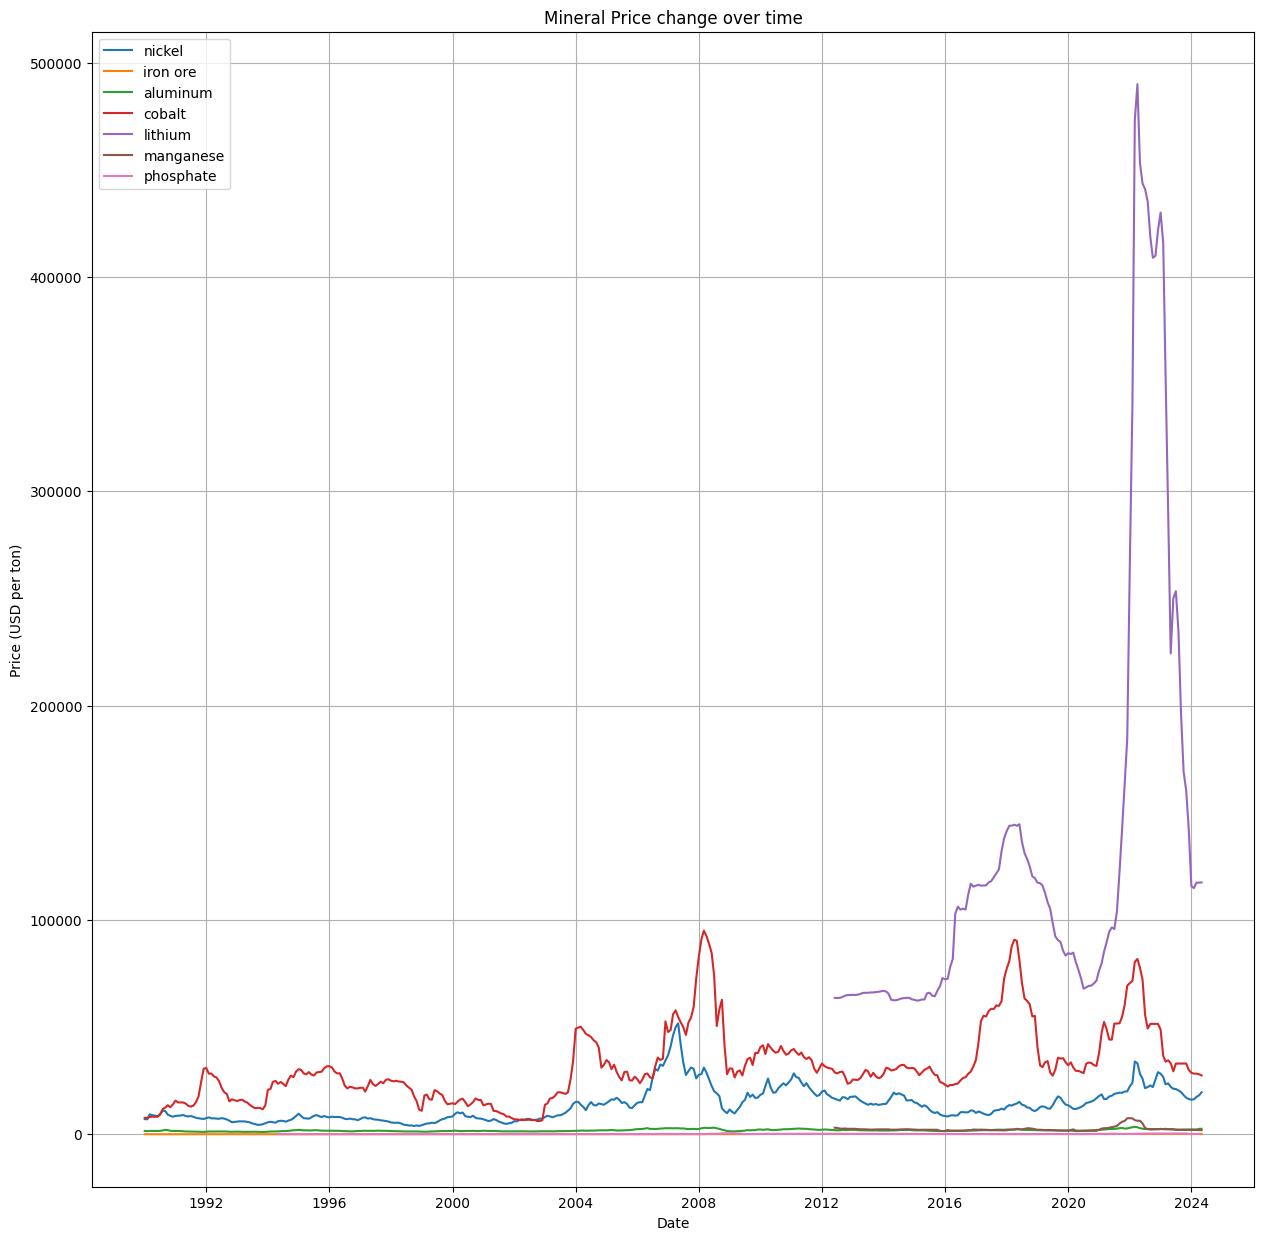

In [ ]:
plt.figure(figsize = (15, 15))
for column in minerals_df.columns.to_list():
  plt.plot(minerals_df.index, minerals_df[column], label = column)
plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD per ton)")
plt.title("Mineral Price change over time")
plt.savefig("mineral_prices")
plt.show()

Function to construct a DataFrame for the different portfolios containing the scaled prices of the minerals

In [ ]:
def construct_portfolio(mineral_composition, minerals_df):
  battery_minerals = list(mineral_composition.keys())
  # Try to remove "oxygen"
  try:
    battery_minerals.remove("oxygen")
  except:
    pass

  battery_df = minerals_df[battery_minerals].dropna()

  for mineral, quantity in mineral_composition.items():
    if mineral != "oxygen":
      battery_df[mineral] = battery_df[mineral] * quantity

  battery_df["price (usd/ton)"] = battery_df[battery_minerals].sum(axis = 1)
  return battery_df

Function to graph the portfolio

In [ ]:
def plot_portfolio(portfolio_df, battery):
  plt.figure(figsize = (12, 9))
  columns = portfolio_df.columns.to_list()
  plt.plot(portfolio_df.index, portfolio_df[columns[-1]])
  plt.xlabel("Date")
  plt.ylabel(battery)
  plt.grid()
  plt.title(battery + " (USD/ton)")
  plt.savefig(battery + "_plot")
  plt.show()

The main function - run this!

LFP Portfolio:


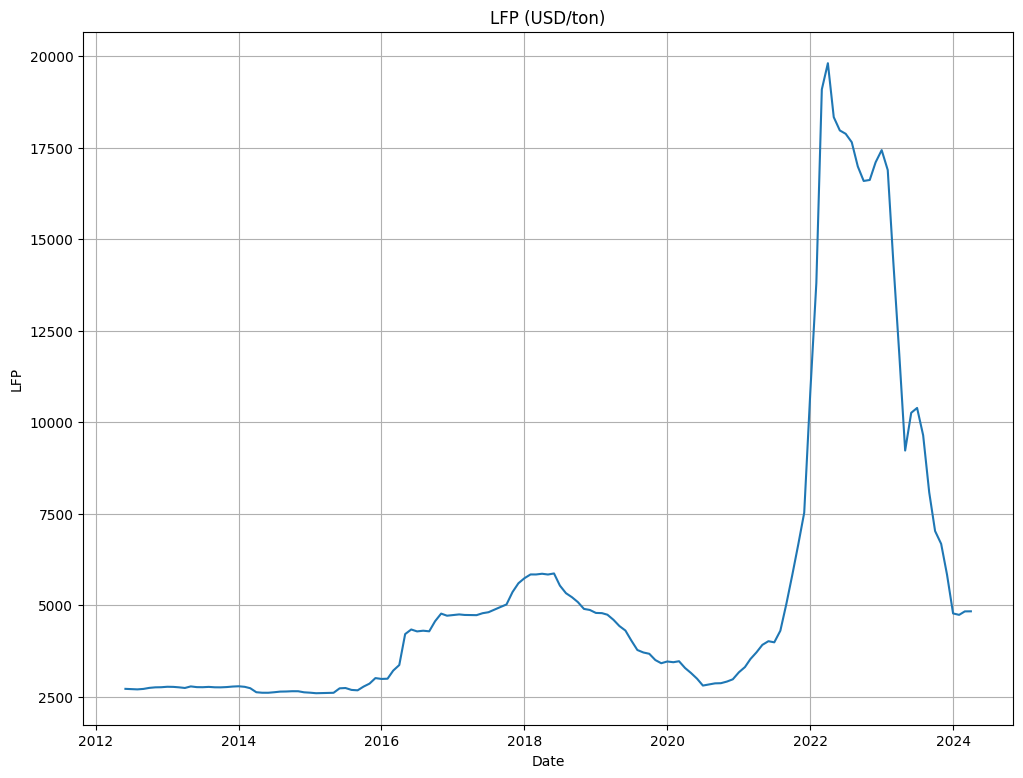

NMC-111 Portfolio:


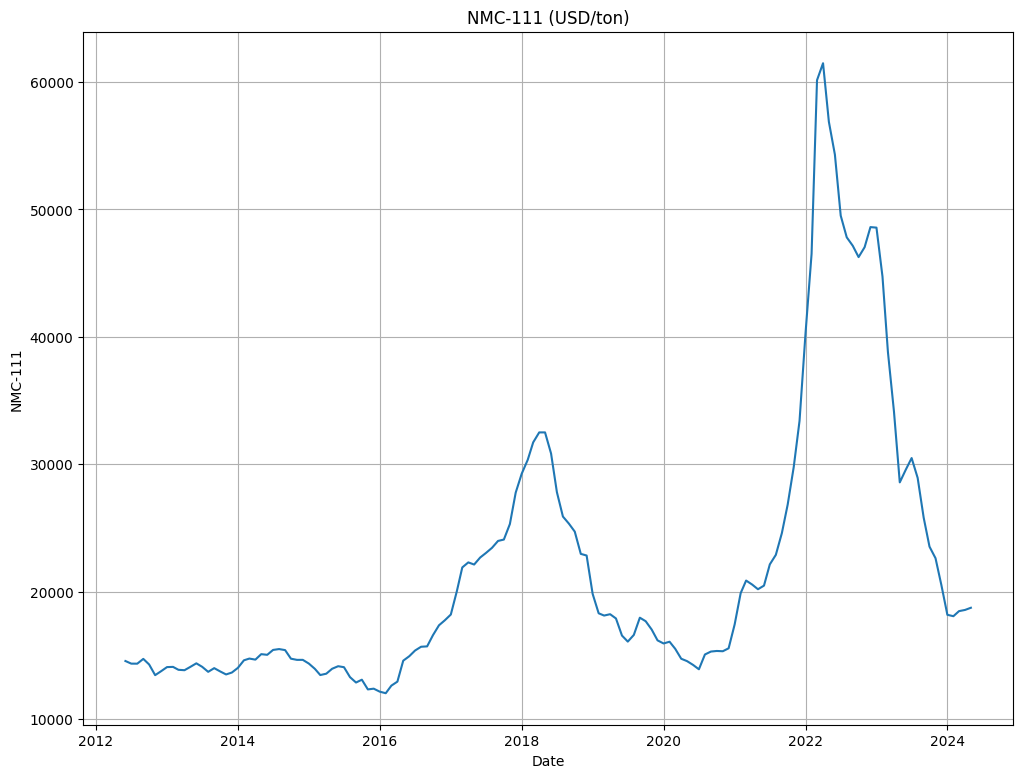

NMC-811 (EV) Portfolio:


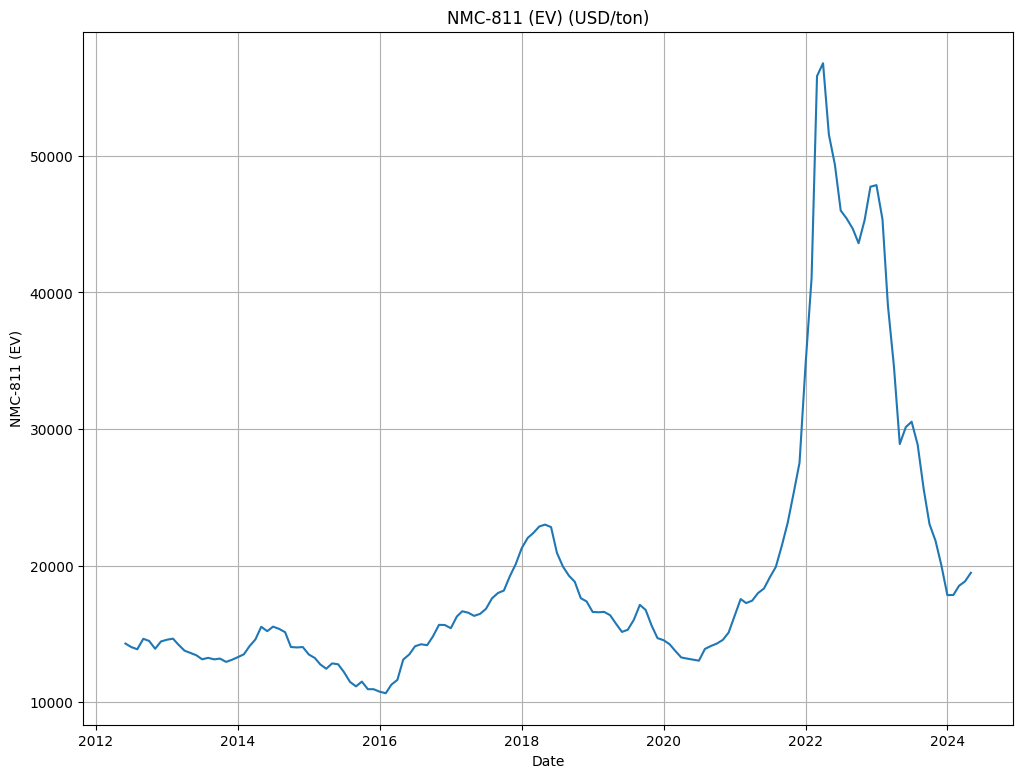

NCA Tesla EV Portfolio:


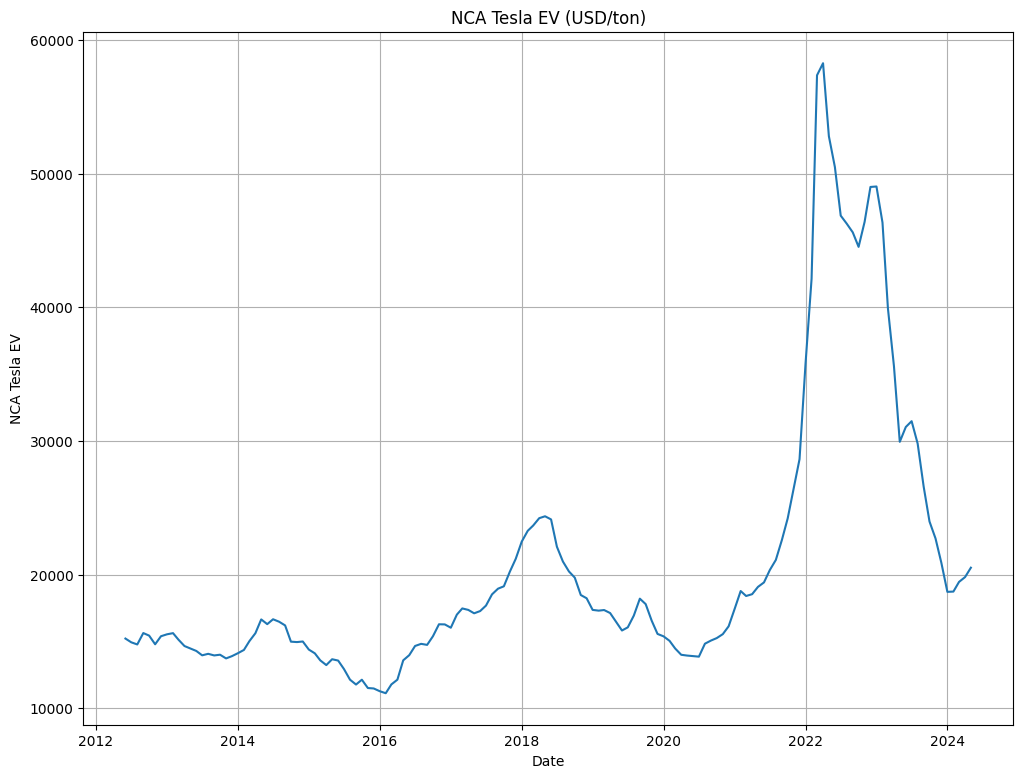

LCO electronics Portfolio:


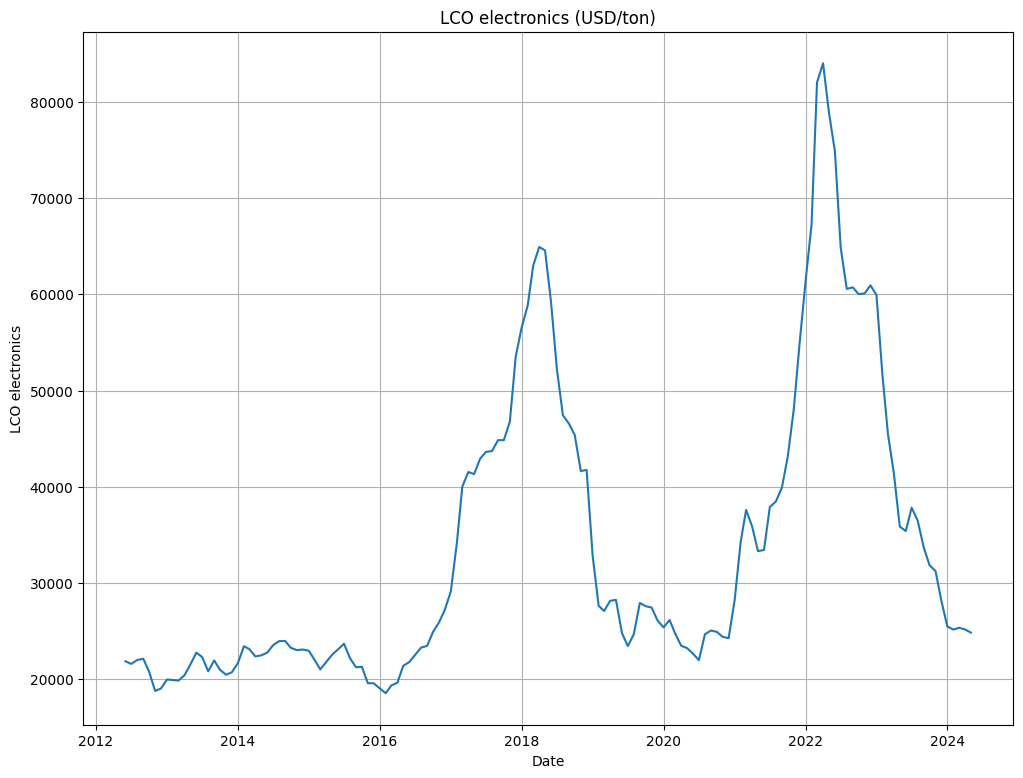

In [ ]:
# Main function
def main():
  for battery, mineral_composition in portfolios.items():
    print(battery + " Portfolio:")
    check_correct_composition(mineral_composition)
    battery_df = construct_portfolio(mineral_composition, minerals_df)
    battery_df.to_csv(battery + " portfolio" + ".csv")
    plot_portfolio(battery_df, battery)

main()

In [ ]:
## Old function using data from FRED Database

# def construct_portfolio(mineral_composition):
#   # Create an empty DataFrame to concatenate the different minerals DataFrames to
#   portfolio_df = pd.DataFrame()
#   for mineral in mineral_composition:
#     #################### CLEANING ####################
#     # Convert the .csv to a DataFrame
#     raw_mineral_df = pd.read_csv(mineral + ".csv")
#     # Rename column names
#     mineral_price = mineral + " price"
#     raw_mineral_df.columns = ["date", mineral_price]
#     mineral_df = raw_mineral_df.set_index("date")
#     # Convert string datetimes to datetime objects
#     mineral_df.index = pd.to_datetime(mineral_df.index)
#     # Clean the columns (sometimes prices have commas in them)
#     try:
#       mineral_df[mineral_price] = mineral_df[mineral_price].str.replace(",", "").astype(float)
#     except:
#       mineral_df[mineral_price] = pd.to_numeric(mineral_df[mineral_price], errors = "coerce")

#     # Apply the scaling from the composition
#     mineral_df[mineral_price] = mineral_df[mineral_price] * mineral_composition[mineral]
#     portfolio_df = portfolio_df.join(mineral_df, how = "outer")

#   # Sum the scaled prices of all the minerals
#   portfolio_df["lfp price"] = portfolio_df.iloc[:, :].sum(axis=1)
#   portfolio_df = portfolio_df.sort_index()

#   # Deal with missing values (TO DO)
#   # Linear interpolation?

#   return portfolio_df